This notebook will discuss three strategies to be used in making stock trading decisions using quotes from arbitrarily selected companies representing two industries. We will discuss a moving average crossover trading strategy, as well as trading based on predicted probabilities produced by training a neural network on historical data. These approaches will be contrasted with the simple purchase and holding of the given stocks. This notebook implements some examples from the vignettes [Stock Data Analysis with Python (Second Edition)](https://ntguardian.wordpress.com/2018/07/17/stock-data-analysis-python-v2/) and [Time Series Basics with Pandas and Finance Data](https://www.cntk.ai/pythondocs/CNTK_104_Finance_Timeseries_Basic_with_Pandas_Numpy.html).

Let's import the modules to be used in the first part of our analysis:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%matplotlib notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

from pandas_datareader import data

Populating the interactive namespace from numpy and matplotlib


Now we will define a function to retrieve quotes using pandas datareader. This function is given a start and end date as well as a list of symbols. We'll create two lists of symbols from which to retrieve quotes: one for the three motor vehicle manufactures Honda (HMC), Toyota (TM), and Harley Davidson (HOG), and one for the three mobile service providers Verizon (VZ), AT&T (T), and Sprint (S). We'll call the function once for each list, producing two dictionaries with three data frames each. We'll select AT&T as the first quote for analysis.

In [2]:
def download_quotes(symbols, start, end):
    dfs = {}
    for symbol in symbols:
        quotes = data.DataReader(symbol,"yahoo", start, end)
        dfs[symbol] = quotes
    return dfs

motor_vehicle_symbols = ['HMC', 'TM', 'HOG']
mobile_symbols = ['VZ', 'T', 'S']

start = pd.datetime(2011,1,3)
end = pd.datetime(2019,6,20)

mobile_stocks = download_quotes(mobile_symbols, start, end)
motor_vehicle_stocks = download_quotes(motor_vehicle_symbols, start, end)

symbol = 'T'
df = mobile_stocks[symbol]

Let's visualize the quotes for AT&T using a candlestick plot. This chart is extremely common in financial analysis due to its intuitive summarization of the open, close, high, and low variables. Days on which the candle is red signify that the stock price decreased and that the bottom end of the box represents the close price, while a black candle indicates that the price increased and that the closing price is represented by the top end.

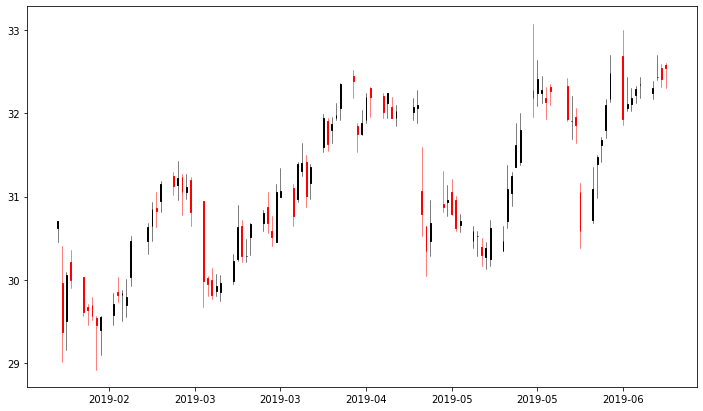

In [10]:
df = df.reset_index()
candlestick_df = df[['Date', 'Open', 'High', 'Low', 'Close']].iloc[-100:,:]
# Converting date to pandas datetime format
candlestick_df["Date"] = mdates.date2num(candlestick_df["Date"])
candlestick_df['MA20'] = candlestick_df['Close'].rolling(20).mean()
candlestick_df['MA50'] = candlestick_df['Close'].rolling(50).mean()
fig, ax = plt.subplots(figsize = (12,7))

# plot the candlesticks
candlestick_ohlc(ax, candlestick_df.values)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

Fast and slow moving averages represent the basis of the moving average crossover trading strategy. A moving average is the the average of the closing prices of all of the days in a specified period prior to the date in question. This chart displays a 20 day fast moving average in black, and a 50 day slow moving average in red.

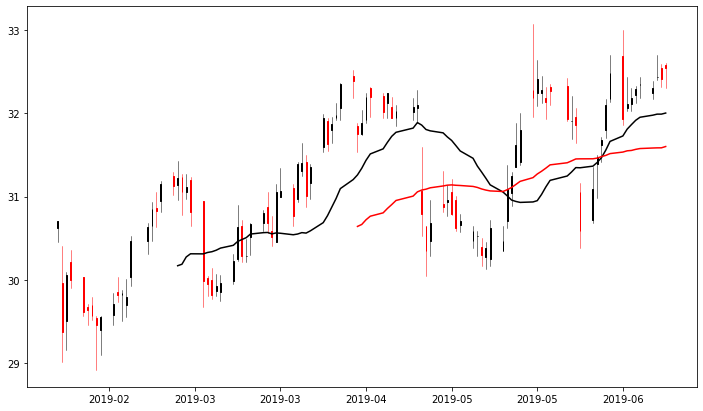

In [14]:
fig, ax = plt.subplots(figsize = (12,7))
candlestick_ohlc(ax, candlestick_df.values)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.plot(candlestick_df['Date'], candlestick_df['MA20'], color='black', label='20 day moving average')
ax.plot(candlestick_df['Date'], candlestick_df['MA50'], color='red', label='50 day moving average')
plt.show()

The points on this chart where the averages cross can be used as trade signals. When the fast moving average crosses the slow moving average from above, this is an indication of a regime change (from a favorable trend to an unfavorable trend), and can be used as a signal to short sell shares. In contrast, when the fast moving averages crosses from the bottom, this can be used as a signal to buy more shares.

Let's define a function to identify the bull and bear (favorable and unfavorable) regimes in our quotes. Subsequently we can mark the dates where regime changes occur as a signal to change our trading strategy. We'll use these signals to produce a data frame which records the stock price at each signal, as well as the change in price from the point of the previous signal, to be used in our backtest function.

In [15]:
def identify_regime(df):

    df['fast_MA'] = np.round(df['Close'].rolling(window=20, center=False).mean(), 2)
    df['slow_MA'] = np.round(df['Close'].rolling(window=50, center=False).mean(), 2)
    df['averages_diff'] = df['fast_MA'] - df['slow_MA']

    df['Regime'] = np.where(df['averages_diff'] > 0 , 1, 0)
    df['Regime'] = np.where(df['averages_diff'] < 0, -1, df['Regime'])
    
    return df

def identify_trading_signals(df):
    
    regime_orig = df.loc[:, 'Regime'].iloc[-1]
    df.loc[:,'Regime'].iloc[-1] = 0
    df['Signal'] = np.sign(df['Regime'] - df['Regime'].shift(1))
    df.loc[:, 'Regime'].iloc[-1] = regime_orig
    df.loc[df['Signal'] == 1, 'Close']

    buy_signals = pd.DataFrame({'Price': df.loc[df['Signal'] == 1, 'Close'],
                         'Regime': df.loc[df['Signal'] == 1, 'Regime'], 'Signal': 'Buy'})

    sell_signals = pd.DataFrame({'Price': df.loc[df['Signal'] == -1, 'Close'],
                         'Regime': df.loc[df['Signal'] == -1, 'Regime'], 'Signal': 'Sell'})  

    signals = pd.concat([buy_signals, sell_signals])
    signals.sort_index(inplace = True)
    signals['price_diff'] = signals['Price'] - signals['Price'].shift(1)

    Price = signals.loc[(signals['Signal'] == 'Buy') & signals['Regime'] == 1, 'Price']
    Profit= signals['price_diff'].loc[(signals["Signal"].shift(1) == "Buy") & 
                                      (signals["Regime"].shift(1) == 1)].tolist()
    
    if len(Price) > len(Profit):
        Price = Price.iloc[0:len(Price)-1]
            
    long_profits = pd.DataFrame({'Price': Price, 'Profit': Profit})
    
    return long_profits

Finally, let's create a function that displays the result of trading based off of these signals. We'll assume the investor has $1,000,000 in their portfolio, but this value is arbitrary since the returns are indicated in terms of the proportion of original investment. The trades will not exceed 20% of the available funds, and trades will be made in batches of 100 shares. The output of this fuction is a series representing the portfolio value at each date upon when a regime change signal occurs. 

In [16]:
def backtest(df, symbol):
    df = identify_regime(df)
    long_profits = identify_trading_signals(df)

    cash = 1000000
    portfolio_start = cash
    portfolio_end = pd.Series(index=long_profits.index)
    port_value = 0.2
    batch = 100

    for row in range(len(long_profits)):

        trade_batches = np.floor(cash * port_value) // np.ceil(batch * long_profits.iloc[row,0]) 
        share_profit = long_profits.iloc[row,1]
        profit = share_profit * trade_batches * batch
        portfolio_end.iloc[row] = (cash + profit) / portfolio_start
        
        cash = max(0, cash + profit)
    
    return portfolio_end

We should compare the backtesting results with a simple buy and hold strategy for the same period. We will define a simple function to calculate the returns using this strategy.

In [17]:
def buy_and_hold(df, start):
    end_portfolio = (df['Close'] / df['Close'].loc[start])
    return end_portfolio

The backtest results for our moving average crossover strategy as a proportion of the starting portfolio value are displayed below, as well as the results of the benchmarking tactic of "betting on the market." We have used the S&P 500 index (symbol SPY) as a representative of the market as a whole, and have plotted the returns from buying and holding SPY alongside the backtests of our other symbols.

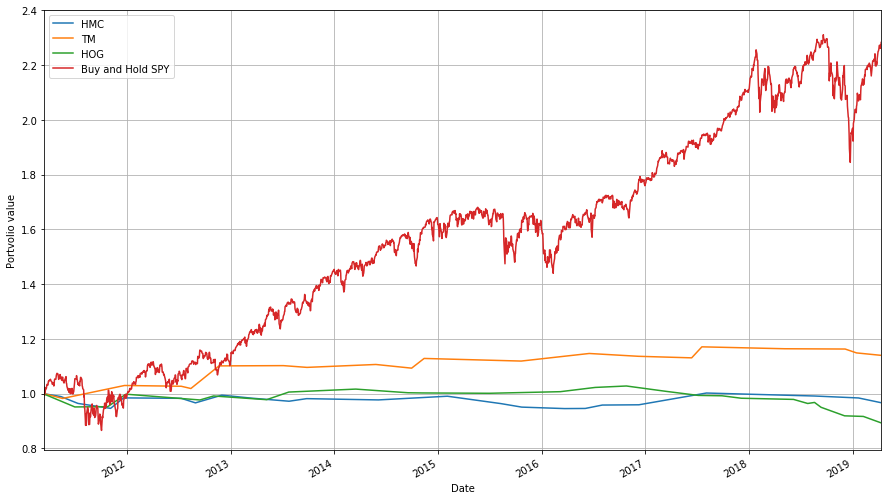

In [18]:
pylab.rcParams['figure.figsize'] = (15, 9)


SPY = download_quotes(['SPY'], start, end)
SPY = buy_and_hold(SPY['SPY'], start)

for symbol in motor_vehicle_symbols:
    plot = backtest(motor_vehicle_stocks[symbol], symbol).plot(label=symbol)

plot.plot(SPY, label = 'Buy and Hold SPY')
plot.set(ylabel='Portvolio value')
leg = plt.legend() 
plt.grid()

Let see what these results like if we simple buy and hold each stock including SPY for the same time period:

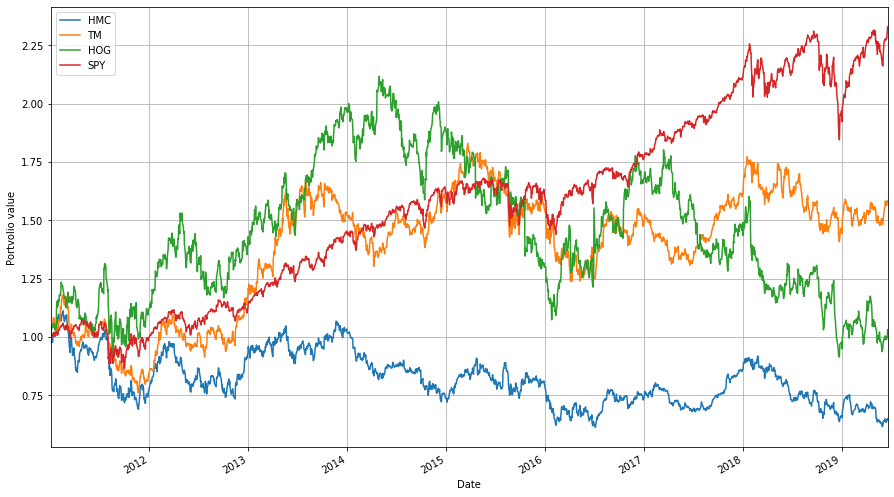

In [19]:
for symbol in motor_vehicle_symbols:
    holds = buy_and_hold(motor_vehicle_stocks[symbol], start)
    plot = holds.plot(label=symbol)
    
plot.set(ylabel='Portvolio value')
plot.plot(SPY, label = 'SPY')
plot.grid()
leg = plot.legend()

From these charts, we can see that none of the our motor vehicle manufacturer stocks using either trading strategy have beaten the market itself. In comparing the moving average crossover strategy with buying and holding stock, in this example the latter is associated with higher returns, but also higher volatility (standard deviation of the returns), and therefore higher risk.

Similarly to the results for the auto symbols, the results for the mobile symbols show that the moving average crossover strategy is associated with less risk, although none of the stocks approach the SPY returns.

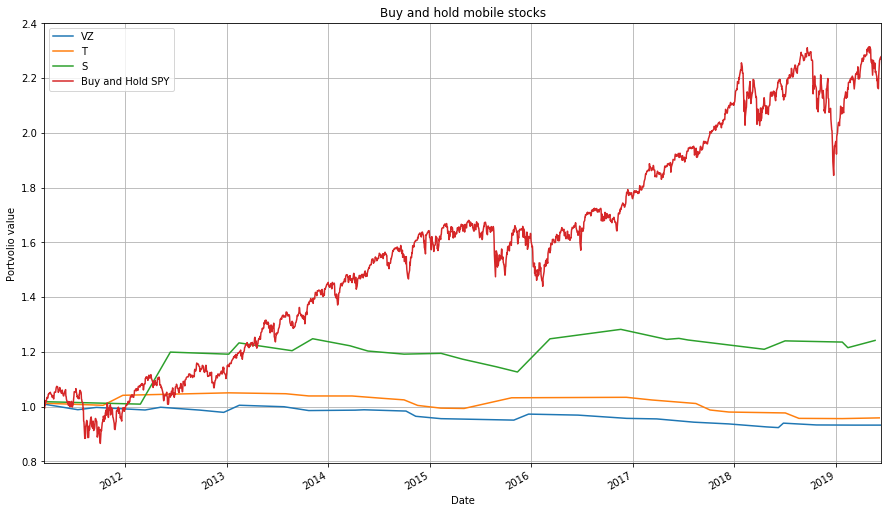

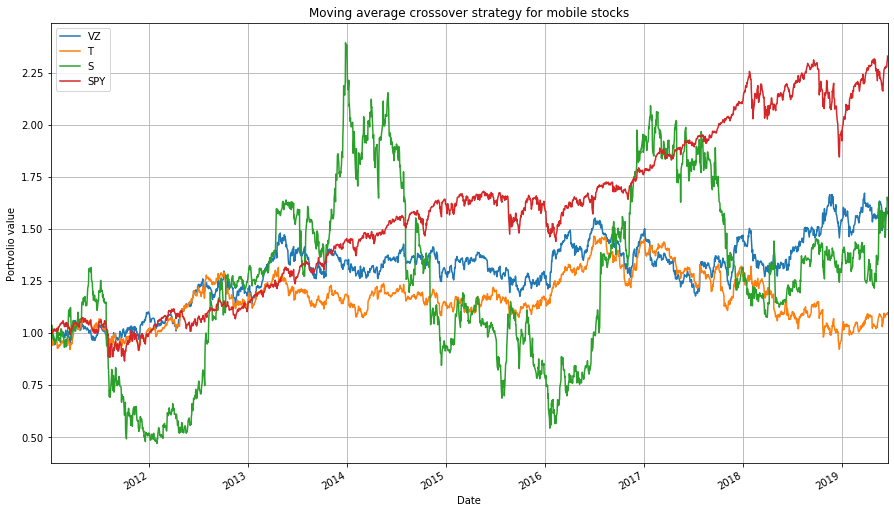

In [20]:
for symbol in mobile_symbols:
    plot = backtest(mobile_stocks[symbol], symbol).plot(label=symbol)

plot.plot(SPY, label = 'Buy and Hold SPY')
plot.set(ylabel='Portvolio value')
leg = plt.legend() 
plt.grid()
title = plt.gca().set_title('Buy and hold mobile stocks')
plt.show()

for symbol in mobile_symbols:
    holds = buy_and_hold(mobile_stocks[symbol], start)
    plot = holds.plot(label=symbol)
    
plot.set(ylabel='Portvolio value')
plot.plot(SPY, label = 'SPY')
plot.grid()
leg = plot.legend()
title = plt.gca().set_title('Moving average crossover strategy for mobile stocks')

The moving average crossover strategy we used appears underpowered in beating the buy and hold strategy. Let's try implementing a predictive algorithm to make our trade decisions in the form of a neural network, and see how the results hold up.

First, we'll implement the modules necesarry for this new step.

In [22]:
import datetime, os, time
import tensorflow as tf

We will present the tuning variables at the beginning of the script for easier modification:

In [31]:
probability_threshold = 0.55 # Threshold used to make trade decision
train_start_date = "2011-02-05"
train_end_date = "2016-12-31"
test_start_date = "2017-01-03"
test_end_date = "2019-06-20"
date_range = 8

This next segment initializes the feature array with the price and volume change from the previous day, as well as one-hot encoding for a price increase from any of the previous days in the training date range. Then we split the data into the training and test sets.

In [33]:
symbol = 'HMC'
df = motor_vehicle_stocks[symbol]

def define_features(df):
    
    predictor_names = []
    # 
    df["percent change"] = np.abs((df["Close"] - df["Close"].shift(1)) / df["Close"]).fillna(0)
    predictor_names.append("percent change")
    df["volume change"] = np.abs((df["Volume"] - df["Volume"].shift(1)) / df["Volume"]).fillna(0)
    predictor_names.append("volume change")

    for index in range(1, date_range+1):
        df["p_" + str(index)] = np.where(df["Close"] > df["Close"].shift(index), 1, 0)
        predictor_names.append("p_" + str(index))

    df["next_day"] = np.where(df["Close"].shift(-1) > df["Close"], 1, 0)
    df["next_day_opposite"] = np.where(df["next_day"] == 1, 0, 1)
    
    return df, predictor_names
    
def split_data(df, predictor_names):

    train = df[train_start_date:train_end_date]
    test = df[test_start_date:test_end_date]
    
    train_features = np.asarray(train[predictor_names], dtype = "float32")
    train_labels = np.asarray(train[["next_day","next_day_opposite"]], dtype="float32")
    
    test_features = np.ascontiguousarray(test[predictor_names], dtype = "float32")
    test_labels = np.ascontiguousarray(test[["next_day","next_day_opposite"]], dtype="float32")

    features = {'train':train, 'test': test, 'train_features':train_features,
               'test_features':test_features, 'train_labels':train_labels,
               'test_labels':test_labels}
    
    return features

features = split_data(df, predictor_names)

The next two functions train the model using the feature array and the label (price increase or decrease) for each consecutive day, and plot the loss from each training iteration.

In [55]:
df, predictor_names = define_features(df)
features = split_data(df, predictor_names)

def create_model(features ,verbose=False):
    model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(features['train_features'].shape[1], activation='tanh'),
            tf.keras.layers.Dense(10, activation='tanh'),
            tf.keras.layers.Dense(features['train_labels'].shape[1], activation='sigmoid')
            ])
    
    model.compile(optimizer='adam', loss='mean_absolute_error',
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='binaryaccuracy'),
                  tf.keras.metrics.Accuracy(name='accuracy'),
                  tf.keras.metrics.Precision(name='precision'),
                  ])
    history = model.fit(features['train_features'], features['train_labels'], epochs=100, verbose=verbose)

    predictions = model.predict(features['test_features'])

    return predictions, history

def plot_loss(history):
    epochs_list = range(1, 101)
    fig, ax = plt.subplots()
    ax.plot(epochs_list, history.history['loss'])
    ax.set(ylabel='Loss', xlabel='Epoch', title='Training loss by epoch')
    plt.show()

predictions, history = create_model(features)

When plotted by epoch, the cost descends across iterations, consistent with the expected pattern.

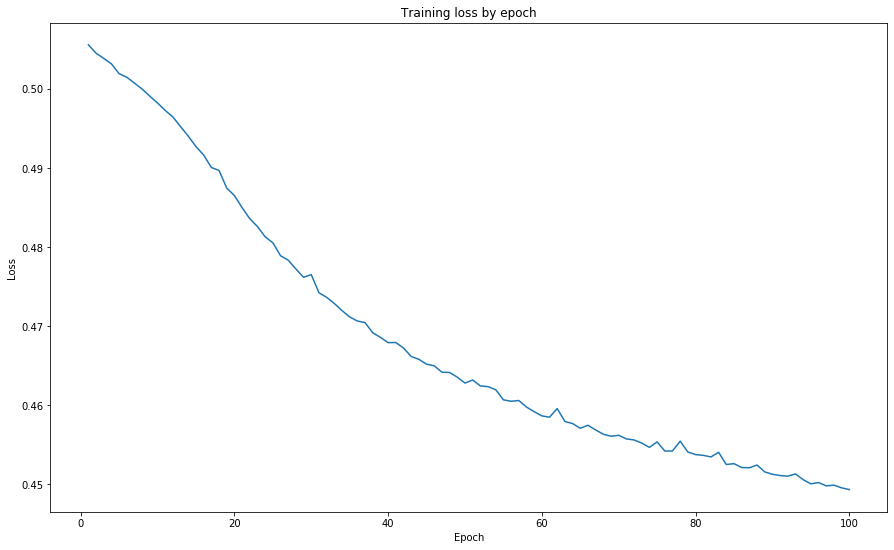

In [49]:
plot_loss(history)

The function predict_quotes applies the trained model to produce predictions for the probability of a price increase or decrease on each day. The monthly returns are then calculated based on making a long sell or short sell (selling a stock and buying it back at a lower price) on each day.

In [48]:
def predict_quotes(predictions, test):

    #this is apparently a df with a column for the probability of an increase,
    # followed by for a decrease
    predicted_probability = predictions
    test["increase_probability"] = pd.Series(predicted_probability[:,0], index = test.index)
    test["decrease_probability"] = predicted_probability[:,1]
    
    # where is the probability of an increase greater than our threshold of 0.55?
    # we will long sell these
    test['long_entries'] = np.where((test.increase_probability 
                                     > probability_threshold), 1, 0)
    
    # same, but for probabilty of decrease / short sell these
    test['short_entries'] = np.where((test.decrease_probability 
                                      > probability_threshold) , -1, 0)
    
    #This column is a -1, 0 or 1 for short sell, do nothing or long sell on each date
    test['positions'] = test['long_entries'].fillna(0) + test['short_entries'].fillna(0)
    test['positions'] = test['positions']/20
    test["pnl"] = test["Close"].diff().shift(-1).fillna(0)* test["positions"] \
    /np.where(test["Close"]!=0,test["Close"],1)
    # percent increase/decrease from previous day
    test["perc"] = (test["Close"] - test["Close"].shift(1)) / test["Close"].shift(1)
    # sum of pnl per month
    monthly_returns = test.pnl.resample("M").sum()
    
    return monthly_returns

For the purposes of our final comparison of the three trading strategies, we will write a single function to implement all steps of the neural network:

In [ ]:

def run_nn(df):
    df, predictor_names = define_features(df)
    features = split_data(df, predictor_names)
    train_features = features['train_features']
    train_labels = features['train_labels']
    test_features = features['test_features']
    test_labels = features['test_labels']
    train = features['train']
    test = features['test']
    predictions = create_model(features)
    monthly_returns = predict_quotes(predictions[0], features['test'])
    
    avg_return = np.mean(monthly_returns)
    std_return = np.std(monthly_returns)
    sharpe = np.sqrt(12) * avg_return / std_return
    
    return (monthly_returns.cumsum()*100) + 1

Finally, we'll define a function that takes a list of symbols, a dictionary with the corresponding stocks, and a data frame containing SPY quotes to produces charts of all three strategies for each stock. Let's see how this looks when applied to the mobile companies:

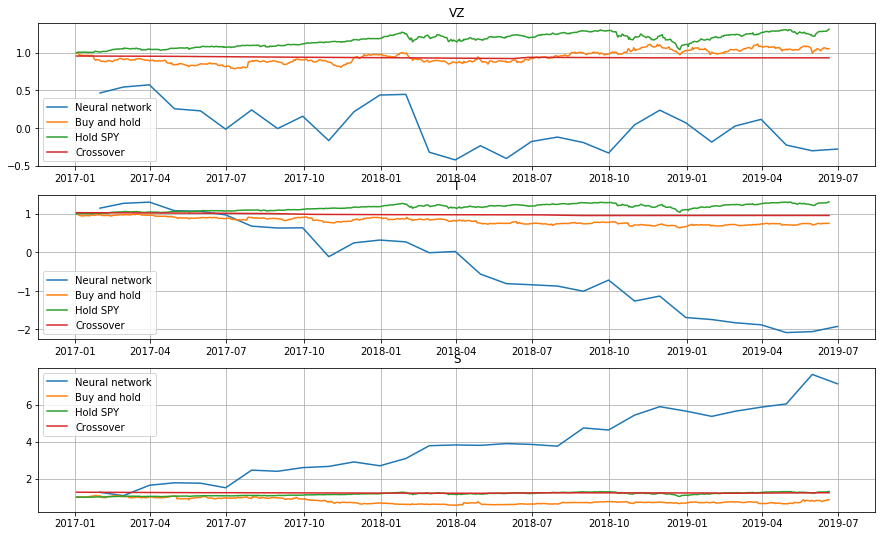

In [53]:
SPY = download_quotes(['SPY'], test_start_date, test_end_date)
SPY =buy_and_hold(SPY['SPY'], test_start_date)

start = pd.datetime(2011,1,3)
end = pd.datetime(2019,6,20)

def plot_strategies(symbol_list, stocks, SPY_quotes):

    for symbol in range(len(symbol_list)):

        nn_data = run_nn(stocks[symbol_list[symbol]])
        hold = buy_and_hold(stocks[symbol_list[symbol]],
                            test_start_date).loc[test_start_date:test_end_date]
        bt = backtest(stocks[symbol_list[symbol]], symbol_list[symbol])
        bt_inter = pd.DataFrame(index=pd.date_range(start=start, end=end), data=bt)
        bt_inter.interpolate(inplace=True)

        plt.subplot(3,1,symbol+1)
        plt.plot(nn_data, label = 'Neural network')
        plt.plot(hold, label='Buy and hold')
        plt.plot(SPY_quotes, label = 'Hold SPY')
        plt.plot(bt_inter.loc[test_start_date:test_end_date], label='Crossover')
        plt.xlabel='Date'
        plt.ylabel='Portfolio Value'
        plt.gca().set_title(symbol_list[symbol])
        plt.legend()
        plt.grid()

    plt.show()
    
plot_strategies(mobile_symbols, mobile_stocks, SPY)

For this particular time period, investing in the market remains the most effective strategy. In contrast, there isn't much evidence that making trading decisions based on our neural network algorithm is worth the risk it presents. Returns using this strategy appear to display a high volatility and yield lower returns than the other strategies in two out of the three above cases. Let's take a look at how these strategies compare using quotes from motor vehicle manufacturers.

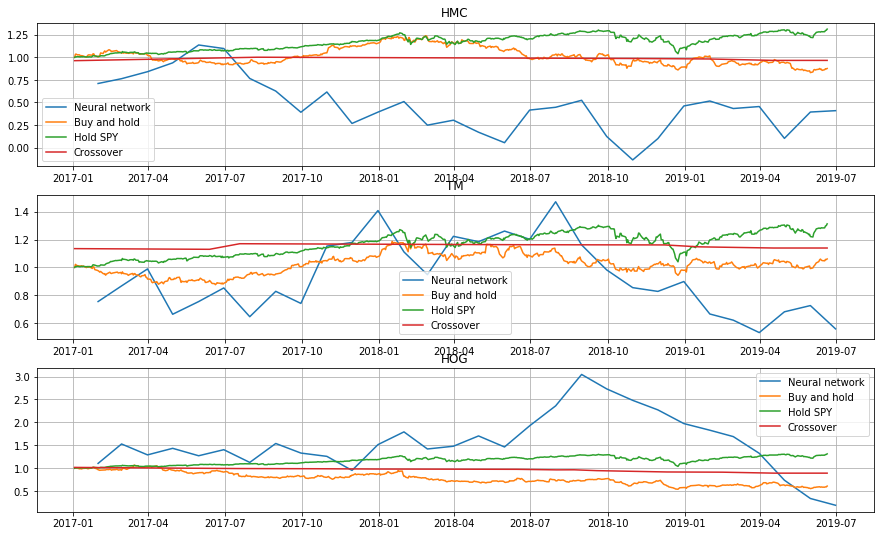

In [54]:
plot_strategies(motor_vehicle_symbols, motor_vehicle_stocks, SPY)

It is still evident that that our current neural network model and parameters result in a highly volatile strategy with many ups and downs, which underperform more often than not when compared with the other strategies. The crossover strategy in its current form stands as a stark contrast as a conservative strategy absent of much risk, but dependent on a significant upturn in the market for return of much consequence.

These results make sense upon consideration of the fact that it is very difficult to establish all of the factors influencing the market and to feed them into a neural network for training. Consider that if we can selected a date range for training prior to the stock market crash of 2007 and 2008 and tested on quotes in the crash date range. The model would not have picked up on the features leading up to that crash because they are probably not even present in the training data to any significant extent.

The results from this example provide support for the [efficient market hypothesis](https://www.investopedia.com/terms/e/efficientmarkethypothesis.asp), which states that it is impossible to outperform the overall market with any given strategy.